In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import gensim.downloader as api
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Input, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout, Bidirectional, GlobalMaxPool1D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adagrad
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Input, Embedding, GRU, GlobalMaxPooling1D, Dense

### Brief description of the problem and data

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

The challenge problem involves natural language processing (NLP) techniques to classify tweets into two categories: disaster tweets and non-disaster tweets. The dataset consists of two main components: a training set and a test set. The training set contains 7,613 rows and 5 columns, while the test set contains 3,263 rows and 4 columns. Each row represents a tweet, and the columns include 'id', 'keyword', 'location', 'text', and 'target' (only available in the training set).

The 'text' column contains the actual tweet text, while the 'target' column in the training set indicates whether the tweet is related to a disaster (target=1) or not (target=0). The 'keyword' and 'location' columns provide additional contextual information about the tweet, such as keywords associated with the tweet or the location from which it was posted.

The data has missing values in the 'keyword' and 'location' columns, with non-null counts indicating the presence of missing values. The 'keyword' column has 7552 non-null values in the training set and 3237 non-null values in the test set, while the 'location' column has 5080 non-null values in the training set and 2158 non-null values in the test set.

The structure of the data is tabular, with rows representing individual tweets and columns representing different attributes of the tweets. The 'text' column, which contains the tweet text, is of primary interest for NLP tasks such as sentiment analysis or classification. Additionally, the 'keyword' and 'location' columns may provide useful contextual information for improving model performance. Overall, the task involves leveraging NLP techniques to analyze and classify tweet data based on their content into disaster and non-disaster categories.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_copy = train.copy()
test_copy = test.copy()
print('Sample of Test:\n')
test.head(5)

Sample of Test:



,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
print('Sample of Train:\n')
train.head(5)

Sample of Train:



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

We begins with an examination of the class distribution in the target variable, revealing a slight imbalance between disaster and non-disaster tweets, with 43% classified as disaster tweets and 57% as non-disaster tweets. Further investigation into tweet locations highlights urban hubs like New York and California as major contributors to tweet activity, both in disaster and non-disaster contexts. Additionally, global centers like the United States and the United Kingdom exhibit significant tweet volumes, indicating the global reach of Twitter in capturing real-time events.

Next, the analysis delves into the textual characteristics of disaster and non-disaster tweets, revealing nuanced differences in word length density, unique word count, and stop word distribution. Disaster tweets tend to be more densely packed with information, with higher word densities and longer mean word lengths compared to non-disaster tweets. Moreover, disaster tweets exhibit more intense bursts of punctuation and a higher frequency of hashtags and mentions, indicating differences in communication styles between the two categories.

Further exploration through n-gram analysis uncovers distinct patterns in word usage between disaster and non-disaster contexts. Disaster-related terms like 'wildfire' and 'suicide bomber' dominate disaster tweets, reflecting the urgency and gravity of such situations. Conversely, non-disaster tweets feature more commonplace language, with phrases like 'liked a youtube video' and 'reddit will now quarantine' prevailing in the discourse.

To prepare the text data for analysis, several cleaning procedures are applied, including lowercasing, punctuation removal, URL removal, HTML tag removal, emoji removal, stop word removal, and stemming. These preprocessing steps ensure standardized text data, facilitating downstream analysis tasks such as sentiment analysis or text classification.

Overall, the EDA provides valuable insights into the characteristics of disaster and non-disaster tweets, laying the groundwork for subsequent analysis tasks like sentiment analysis, topic modeling, or predictive modeling to classify tweets into their respective categories.

#### Class Imbalance: Target

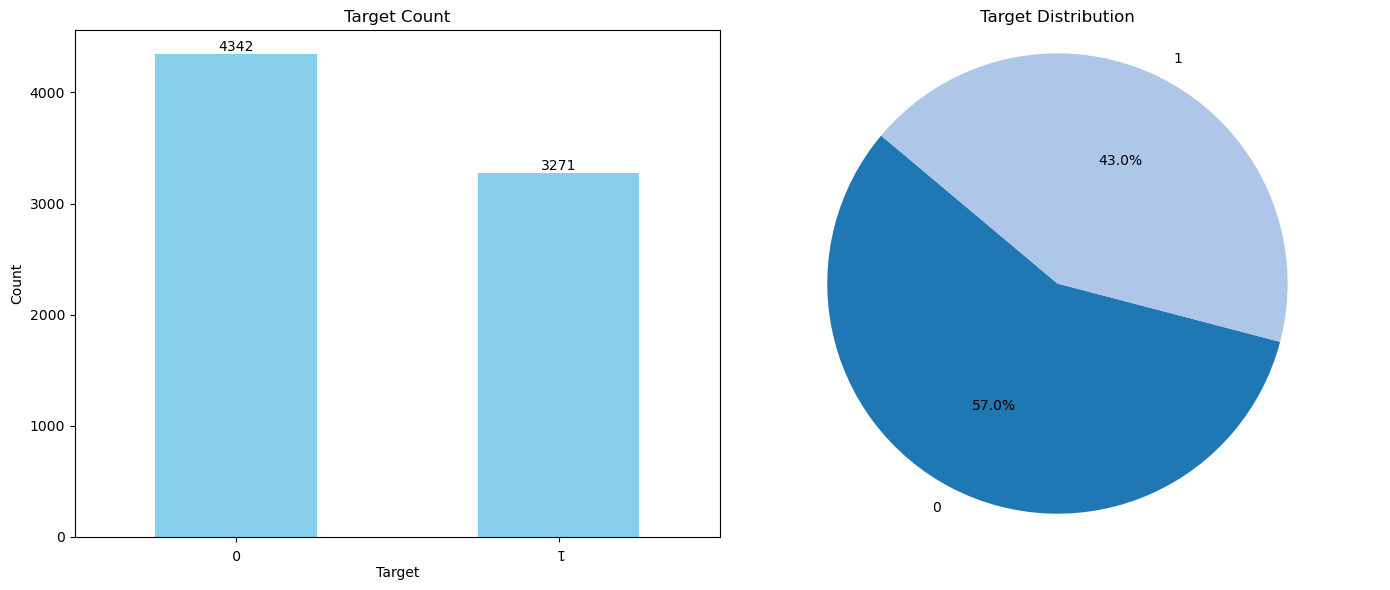

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cnt_srs = train_copy['target'].value_counts()
cnt_srs.plot(kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Target Count')
axs[0].set_xlabel('Target')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=180)

for i, count in enumerate(cnt_srs):
    axs[0].text(i, count + 0.1, str(count), ha='center', va='bottom')

axs[1].pie(cnt_srs, labels=cnt_srs.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
axs[1].set_title('Target Distribution')
axs[1].axis('equal')
plt.tight_layout()
plt.show()


The target column in the training dataset indicates that there are 4,342 records classified as 0 (non-disaster tweets) and 3,271 records classified as 1 (disaster tweets). This distribution translates to 43% for disaster tweets and 57% for non-disaster tweets. The data exhibits a slight imbalance, with a higher proportion leaning towards non-disaster tweets.

#### Non-Disaster and Disaster Tweet by Location

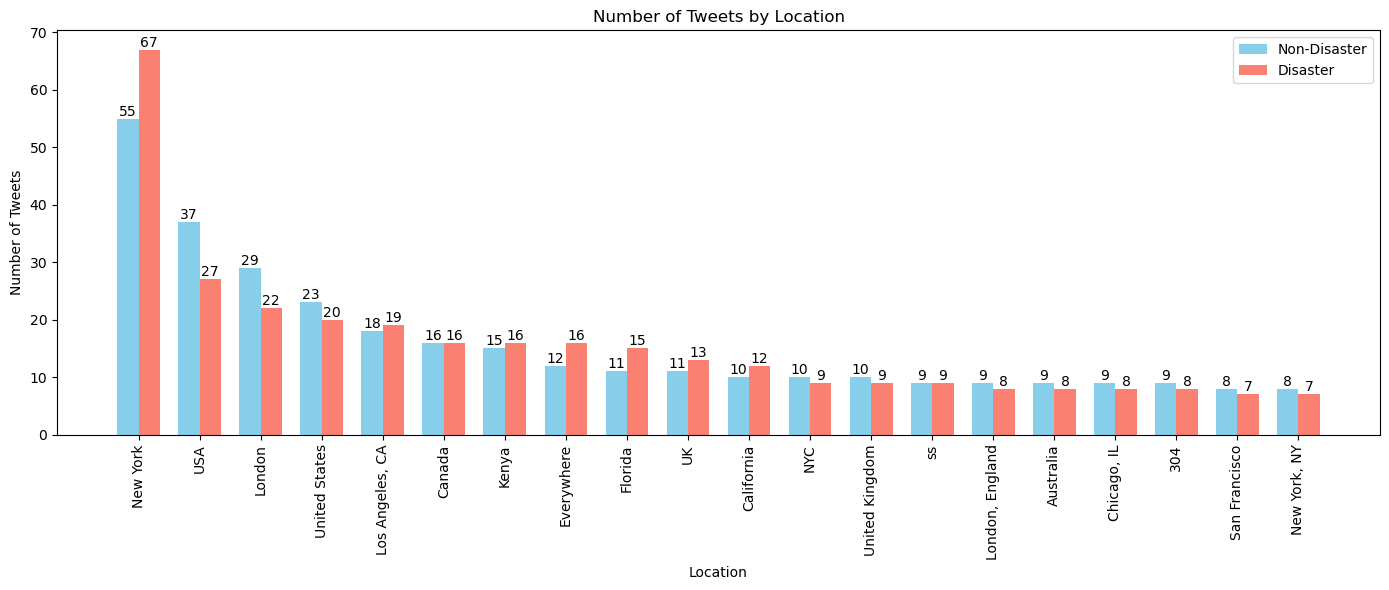

In [8]:
disaster = train_copy[train_copy["target"] == 1]
non_disaster = train_copy[train_copy["target"] == 0]

cnt_disaster = disaster['location'].value_counts().head(20)
cnt_non_disaster = non_disaster['location'].value_counts().head(20)

x = np.arange(len(cnt_non_disaster))
plt.figure(figsize=(14, 6))

bar_width = 0.35  
plt.bar(x - bar_width/2, cnt_non_disaster.values, bar_width, color='skyblue', label="Non-Disaster")
plt.bar(x + bar_width/2, cnt_disaster.values, bar_width, color='salmon', label="Disaster")

for i, v in enumerate(cnt_non_disaster.values):
    plt.text(i - bar_width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(cnt_disaster.values):
    plt.text(i + bar_width/2, v, str(v), ha='center', va='bottom')

plt.title('Number of Tweets by Location')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=x, labels=cnt_non_disaster.index, rotation=90)  # Set the tick positions and labels
plt.legend()
plt.tight_layout()

plt.show()

The location with the highest number of tweets, both related to disasters and non-disasters, is New York state, with variations such as "New York," "NYC," and "New York, NY" comprising a total of 73 non-disaster tweets and 83 disaster tweets. California ranks as the state with the second-highest tweet count, with variations like "Los Angeles, CA," "California," and "San Francisco" accumulating 36 non-disaster tweets and 38 disaster tweets. 

The United States ranks as the country with the highest tweet count, with variations like "USA" and "United States" totaling 60 non-disaster tweets and 47 disaster tweets not including individual cities or states. On the international scale, the United Kingdom secured the second spot, with variations like "UK" and "United Kingdom" not including individual cities or provinces, amassing 21 non-disaster tweets and 22 disaster tweets.

These numbers suggest that urban hubs and densely populated regions tend to generate more tweet activity, possibly due to a higher concentration of users and a greater likelihood of both disasters and non-disaster events occurring. Additionally, it highlights the global reach and significance of platforms like Twitter in capturing real-time information and discussions around various events and incidents.

#### Word Length Density for Non-Disaster vs Disaster Tweets

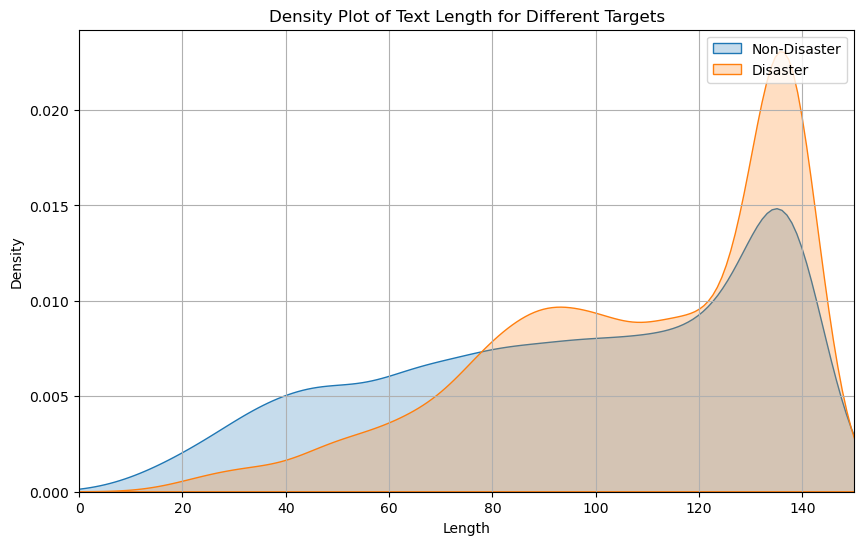

In [9]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)
train_copy['length'] = train_copy['text'].apply(len) 
plt.rcParams['figure.figsize'] = (10.0, 6.0)
sns.kdeplot(train_copy[train_copy['target'] == 0]['length'], fill=True, label='Non-Disaster')
sns.kdeplot(train_copy[train_copy['target'] == 1]['length'], fill=True, label='Disaster')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Density Plot of Text Length for Different Targets')
plt.xlim(0, 150)
plt.grid()
plt.show()

The density of non-disaster tweets reaches its highest point, around 0.015, when the word length is approximately 138 words. Initially, there's a slight peak at a density of around 0.005, occurring around 40 words, followed by a more significant peak at 0.015. After this peak, the density sharply declines.

In contrast, disaster tweets exhibit a different pattern. Their density surpasses 0.020 at around 138 words, indicating a higher concentration of information compared to non-disaster tweets. The density plot for disaster tweets shows a steady increase, with two notable peaks. The first peak, slightly smaller, occurs at around 90 words with a density of about 0.009. The second peak is more pronounced, reaching above 0.020. Following this peak, the density sharply declines.

These numbers suggest that disaster tweets tend to be more densely packed with information compared to non-disaster tweets, especially evident in the second peak. 

#### Word, UniqueWord, StopWord Text Distribution in Non-Disaster and Disaster Tweets

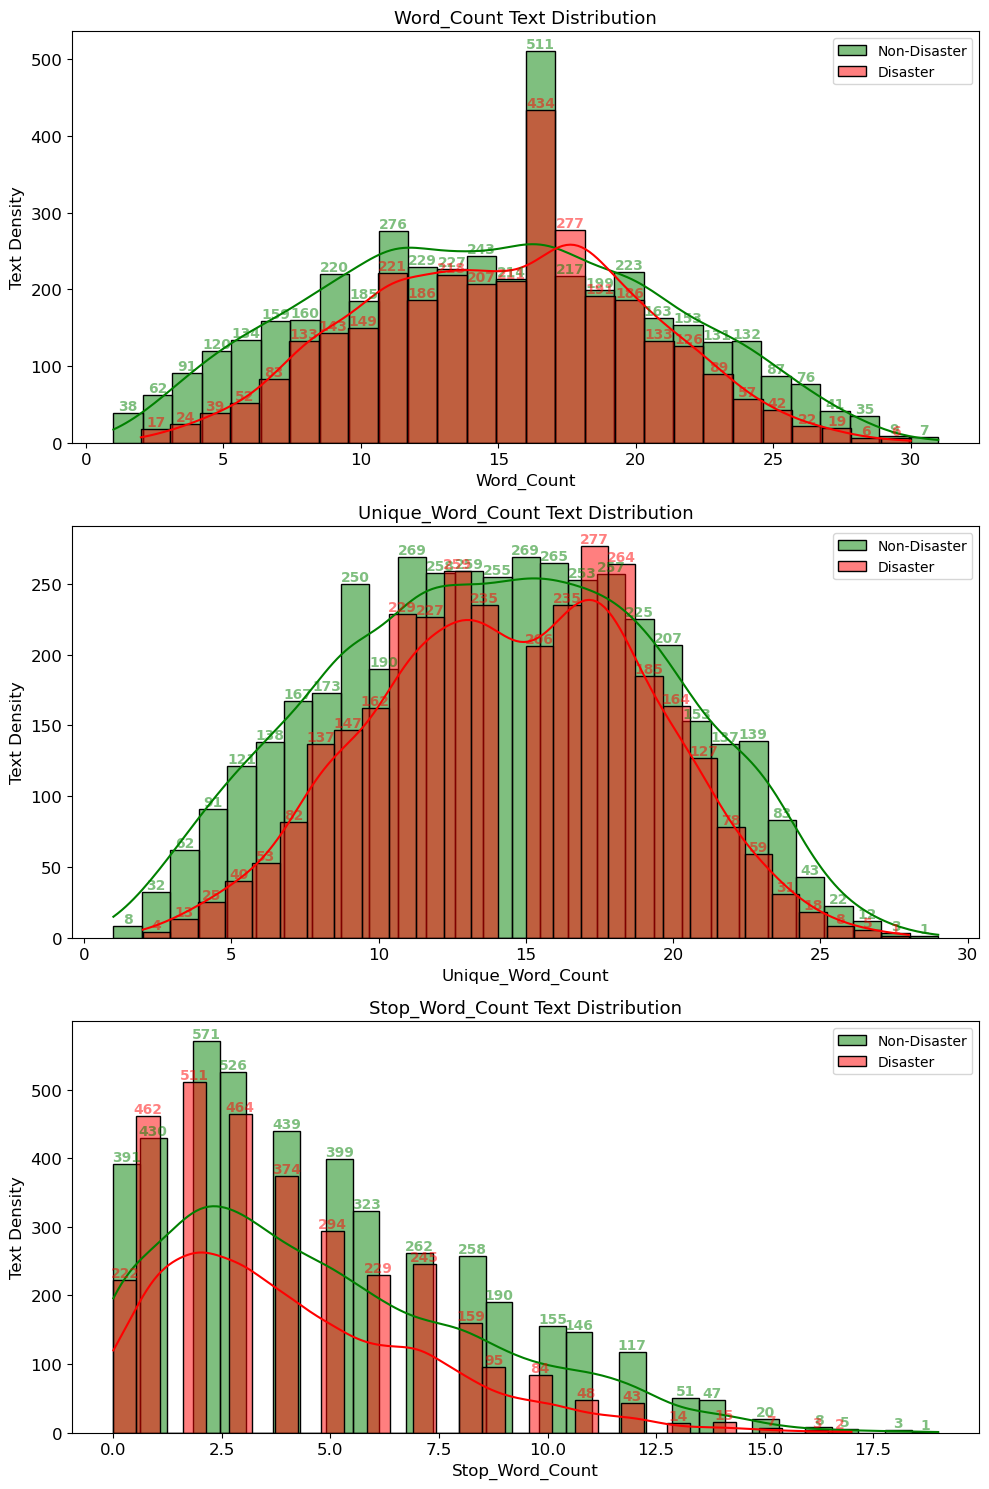

In [10]:
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    return str(text).lower()

def calculate_text_features(df):
    df['Word_Count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['Unique_Word_Count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['Stop_Word_Count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['Url_Count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df['Mean_Word_Length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['Char_Count'] = df['text'].apply(lambda x: len(str(x)))
    df['Punctuation_Count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['Hashtag_Count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['Mention_Count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

def plot_feature_distributions(train_copy, feature, ax):
    sns.histplot(train_copy[train_copy['target'] == 0][feature], label='Non-Disaster', ax=ax, color='green', kde=True)
    sns.histplot(train_copy[train_copy['target'] == 1][feature], label='Disaster', ax=ax, color='red', kde=True)
    ax.set_xlabel(f'{feature}',fontsize=12)
    ax.set_ylabel('Text Density',fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend()
    ax.set_title(f'{feature} Text Distribution', fontsize=13)
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height != 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  
                    height,                             
                    f'{height:.0f}',                    
                    ha='center',                       
                    va='bottom',                      
                    color=bar.get_facecolor(),         
                    fontsize=10,
                    fontweight='bold'
                )

fig, axes = plt.subplots(nrows=3, figsize=(10, 15), dpi=100)

train_copy['text'] = train_copy['text'].apply(preprocess_text)
calculate_text_features(train_copy)
features_to_plot = ['Word_Count', 'Unique_Word_Count', 'Stop_Word_Count']

for i, feature in enumerate(features_to_plot):
    plot_feature_distributions(train_copy, feature, axes[i])

plt.tight_layout()
plt.show()


The Word Text Distribution Graph illustrates the distribution of text density concerning the word count in both Non-Disaster and Disaster tweets. Notably, both types of tweets exhibit similar patterns, with their peak text densities occurring around a word count of 16. Before reaching this peak, both graph lines gradually ascend, hitting their initial peak around word count 11, with Disaster tweets slightly lower at 221 text density compared to Non-Disaster tweets at 276. However, Disaster tweets surpass Non-Disaster tweets in text density only at 17 word count, with 277 for Disaster tweets and 217 for Non-Disaster tweets.

In the Unique Word Text Distribution Graph, there's a distinct gap in unique word count for Disaster tweets around 14 words. Initially, both Disaster and Non-Disaster tweet lines rise steadily, reaching their first peak at around 13 unique words and 259 text density for Disaster tweets. After the gap, Disaster tweet lines slightly decrease before rising again to their second peak at around 18 unique words and 257 text density. Conversely, Non-Disaster tweet lines ascend steadily until they peak at approximately 15 unique words and 269 text density, followed by a gradual decrease. Disaster tweets outpace Non-Disaster tweets in text density only between 17 to 18 unique word count.

The Stop Word Text Distribution Graph indicates the distribution of text density concerning the count of stop words in both types of tweets. Both Disaster and Non-Disaster graph lines follow a similar pattern of gradual increase until they reach their respective peaks, followed by a decline. Non-Disaster tweets peak at a text density of 571 and approximately 2.5 stop words, while Disaster tweets peak at 511 text density and around 2.3 stop words. Disaster tweets exceed Non-Disaster tweets in text density only around 1.0 stop word count, with 462 for Disaster tweets and 430 for Non-Disaster tweets.

These distributions reveal intriguing patterns in how Disaster and Non-Disaster tweets are structured concerning text density and various linguistic aspects. Despite some fluctuations, Disaster tweets generally exhibit slightly lower text densities compared to Non-Disaster tweets across different linguistic measures, except for specific word or stop word counts where Disaster tweets temporarily surpass Non-Disaster tweets. 

#### URL, MeanWordLength, Characters Text Distribution in Non-Disaster and Disaster Tweets

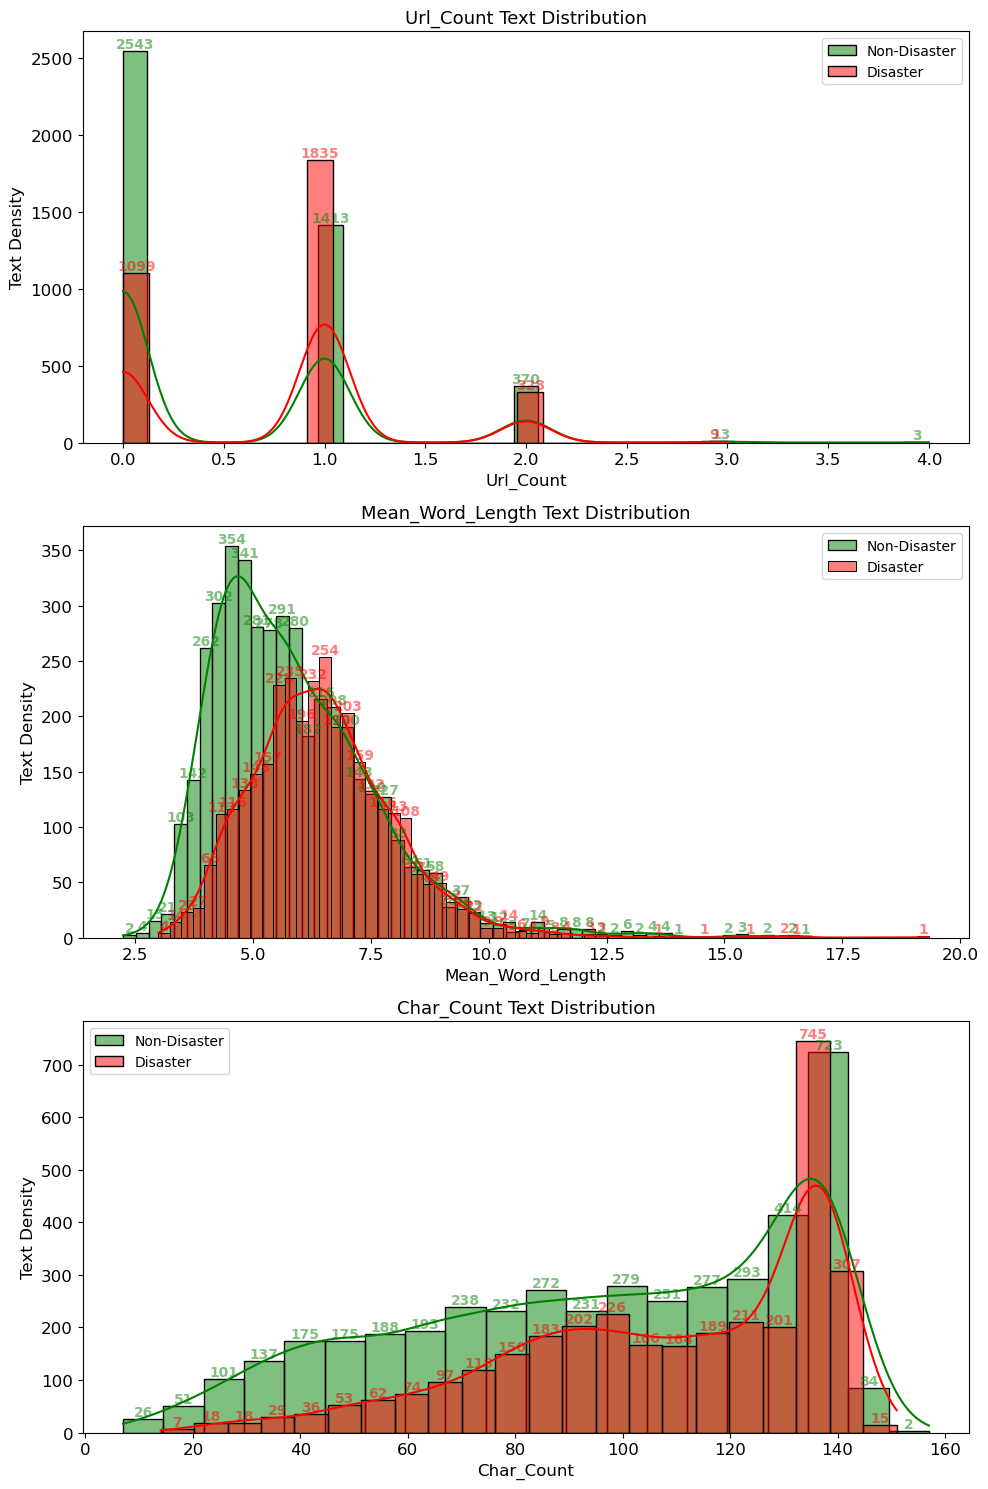

In [11]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 15), dpi=100)

train_copy['text'] = train_copy['text'].apply(preprocess_text)
calculate_text_features(train_copy)
features_to_plot = ['Url_Count', 'Mean_Word_Length', 'Char_Count']

for i, feature in enumerate(features_to_plot):
    plot_feature_distributions(train_copy, feature, axes[i])

plt.tight_layout()
plt.show()


In examining the URL Text Distribution graph, distinct patterns emerge at various URL count intervals. Initially, at around 0.2 URL count, the text density for Disaster tweets is notably lower than that of Non-Disaster tweets, with 1099 and 2543 respectively. However, a shift occurs at the next data point of 1.0 URL count, where Disaster tweets surpass Non-Disaster tweets in text density, registering 1835 and 1413 respectively. The trend continues with a third data point at 2.0 URL count, where Non-Disaster tweets exhibit a higher text density than Disaster tweets, recording 370 and 328 respectively. Beyond this threshold, text density becomes sparser for both Disaster and Non-Disaster tweets.

Moving to the Mean Word Length text distribution graph, a notable contrast emerges in the pace at which Non-Disaster and Disaster tweets reach their peak text densities. Non-Disaster tweets accelerate swiftly to their apex, reaching 351 text density at a mean word length of 3.0, followed by a gradual decline. Conversely, Disaster tweets experience a more gradual ascent, culminating at approximately 254 text density around a mean word length of 6.0.

Examining the Char Count text distribution graph reveals a consistent trend of steady increase followed by a decline in text density for both Non-Disaster and Disaster tweets. Non-Disaster tweets peak at 723 text density and 140 character count, while Disaster tweets reach their zenith at 734 text density and 135 character count. Notably, there's a point of divergence where Disaster tweets surpass Non-Disaster tweets at 145 text character count, with 307 Disaster tweets compared to 84 Non-Disaster tweets.

Insights gleaned from all three graphs suggest nuanced differences in text characteristics between Disaster and Non-Disaster tweets. Despite some fluctuations, Disaster tweets tend to exhibit higher text density and longer mean word lengths compared to Non-Disaster tweets, particularly evident at specific thresholds such as URL count intervals and character counts. 

#### Punctuation, Hashtag, Mentions Text Distribution in Non-Disaster and Disaster Tweets

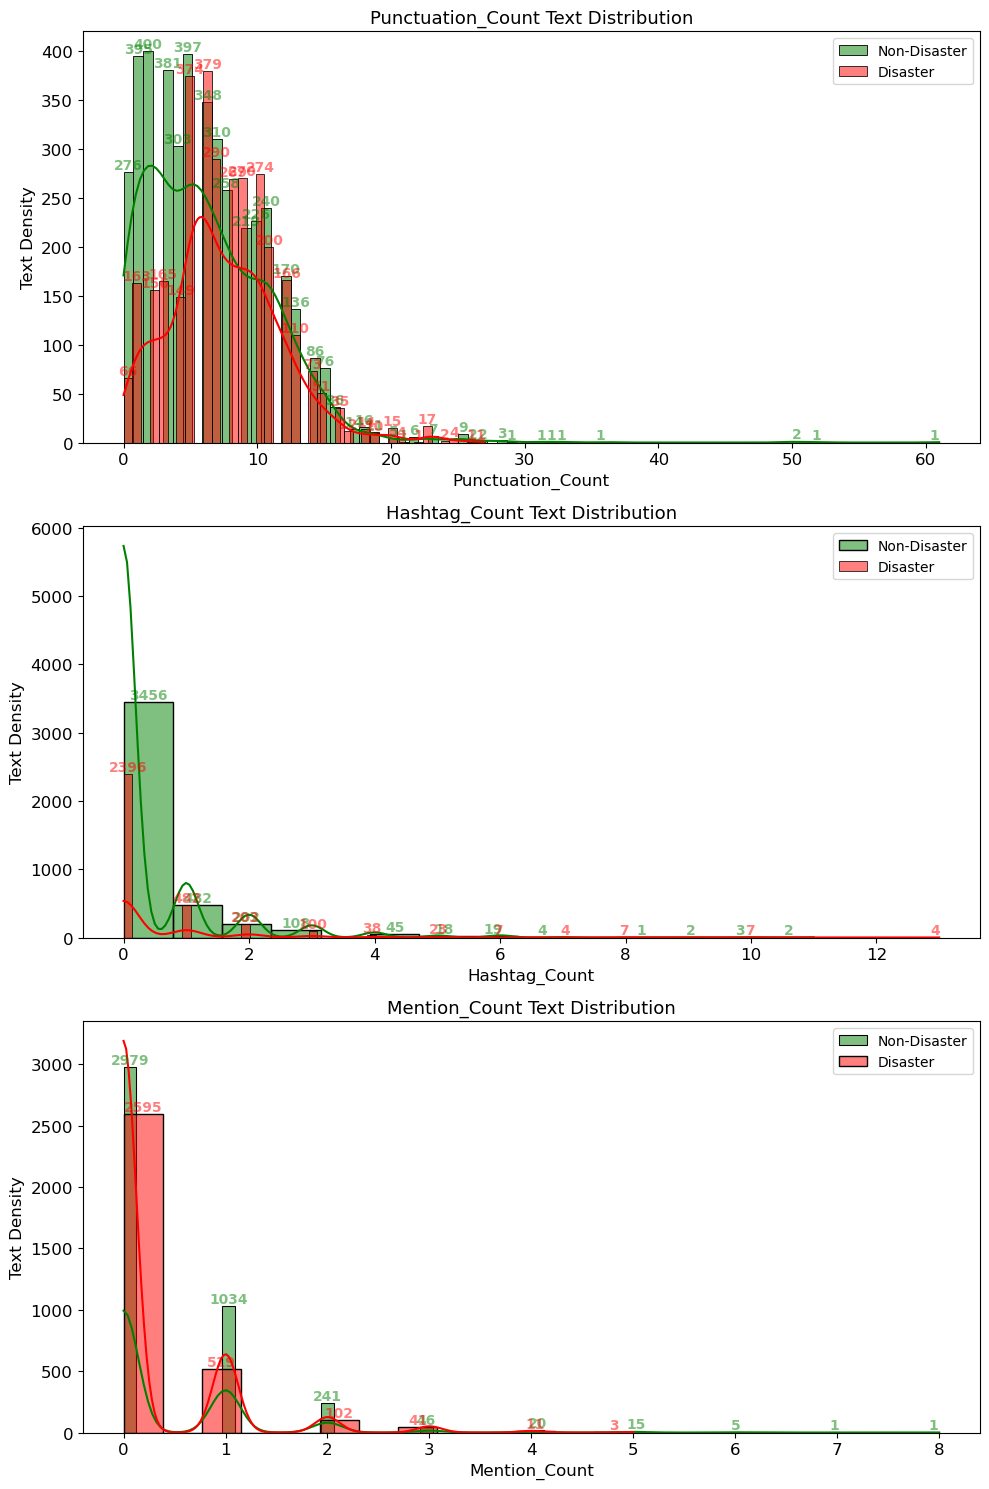

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 15), dpi=100)

train_copy['text'] = train_copy['text'].apply(preprocess_text)
calculate_text_features(train_copy)
features_to_plot = ['Punctuation_Count', 'Hashtag_Count', 'Mention_Count']

for i, feature in enumerate(features_to_plot):
    plot_feature_distributions(train_copy, feature, axes[i])

plt.tight_layout()
plt.show()


In the punctuation text distribution graph, both non-Disaster and Disaster tweets exhibit three distinct peaks. Non-Disaster tweets initially ascend steadily to the first peak at 400 text density and 2 punctuation count, then gradually decline to the second peak at 397 text density and 5 punctuation count, before tapering off to the third peak at 240 text density and 10 punctuation count. Conversely, Disaster tweets follow a different trajectory, ascending steadily to their first peak at 163 text density and 3 punctuation count, then sharply escalating to the second peak at 379 text density and 6 punctuation count, before slowly declining to their third peak at 200 text density and 11 punctuation count.

In the Hashtag count distribution graph, non-Disaster tweets initially dominate, with a text density of 3456 compared to 2396 for Disaster tweets, at 0 to 1 hashtag count. However, both lines quickly level off, showing similar text density of around 482 as the hashtag count increases. This trend continues as the hashtag count rises.

For the mention count distribution graph, non-Disaster tweets start with a higher text density (2979) compared to Disaster tweets (2595) at 0 to 0.5 mention count. The density then decreases steadily. Interestingly, at 3 mention count, both Disaster and non-Disaster tweets converge to similar text density, around 416, as the mention count decreases towards 0.

These distributions reveal nuanced patterns in tweet characteristics. The punctuation graph suggests that Disaster tweets tend to have more intense bursts of punctuation compared to non-Disaster tweets. Additionally, the Hashtag count graph illustrates a convergence of text density as hashtag count increases, indicating a similar engagement with hashtags across both tweet types. Lastly, the mention count graph showcases a shift from initially higher text density in non-Disaster tweets to eventual parity with Disaster tweets as mention count rises, hinting at a convergence in communication style as mention count increases.

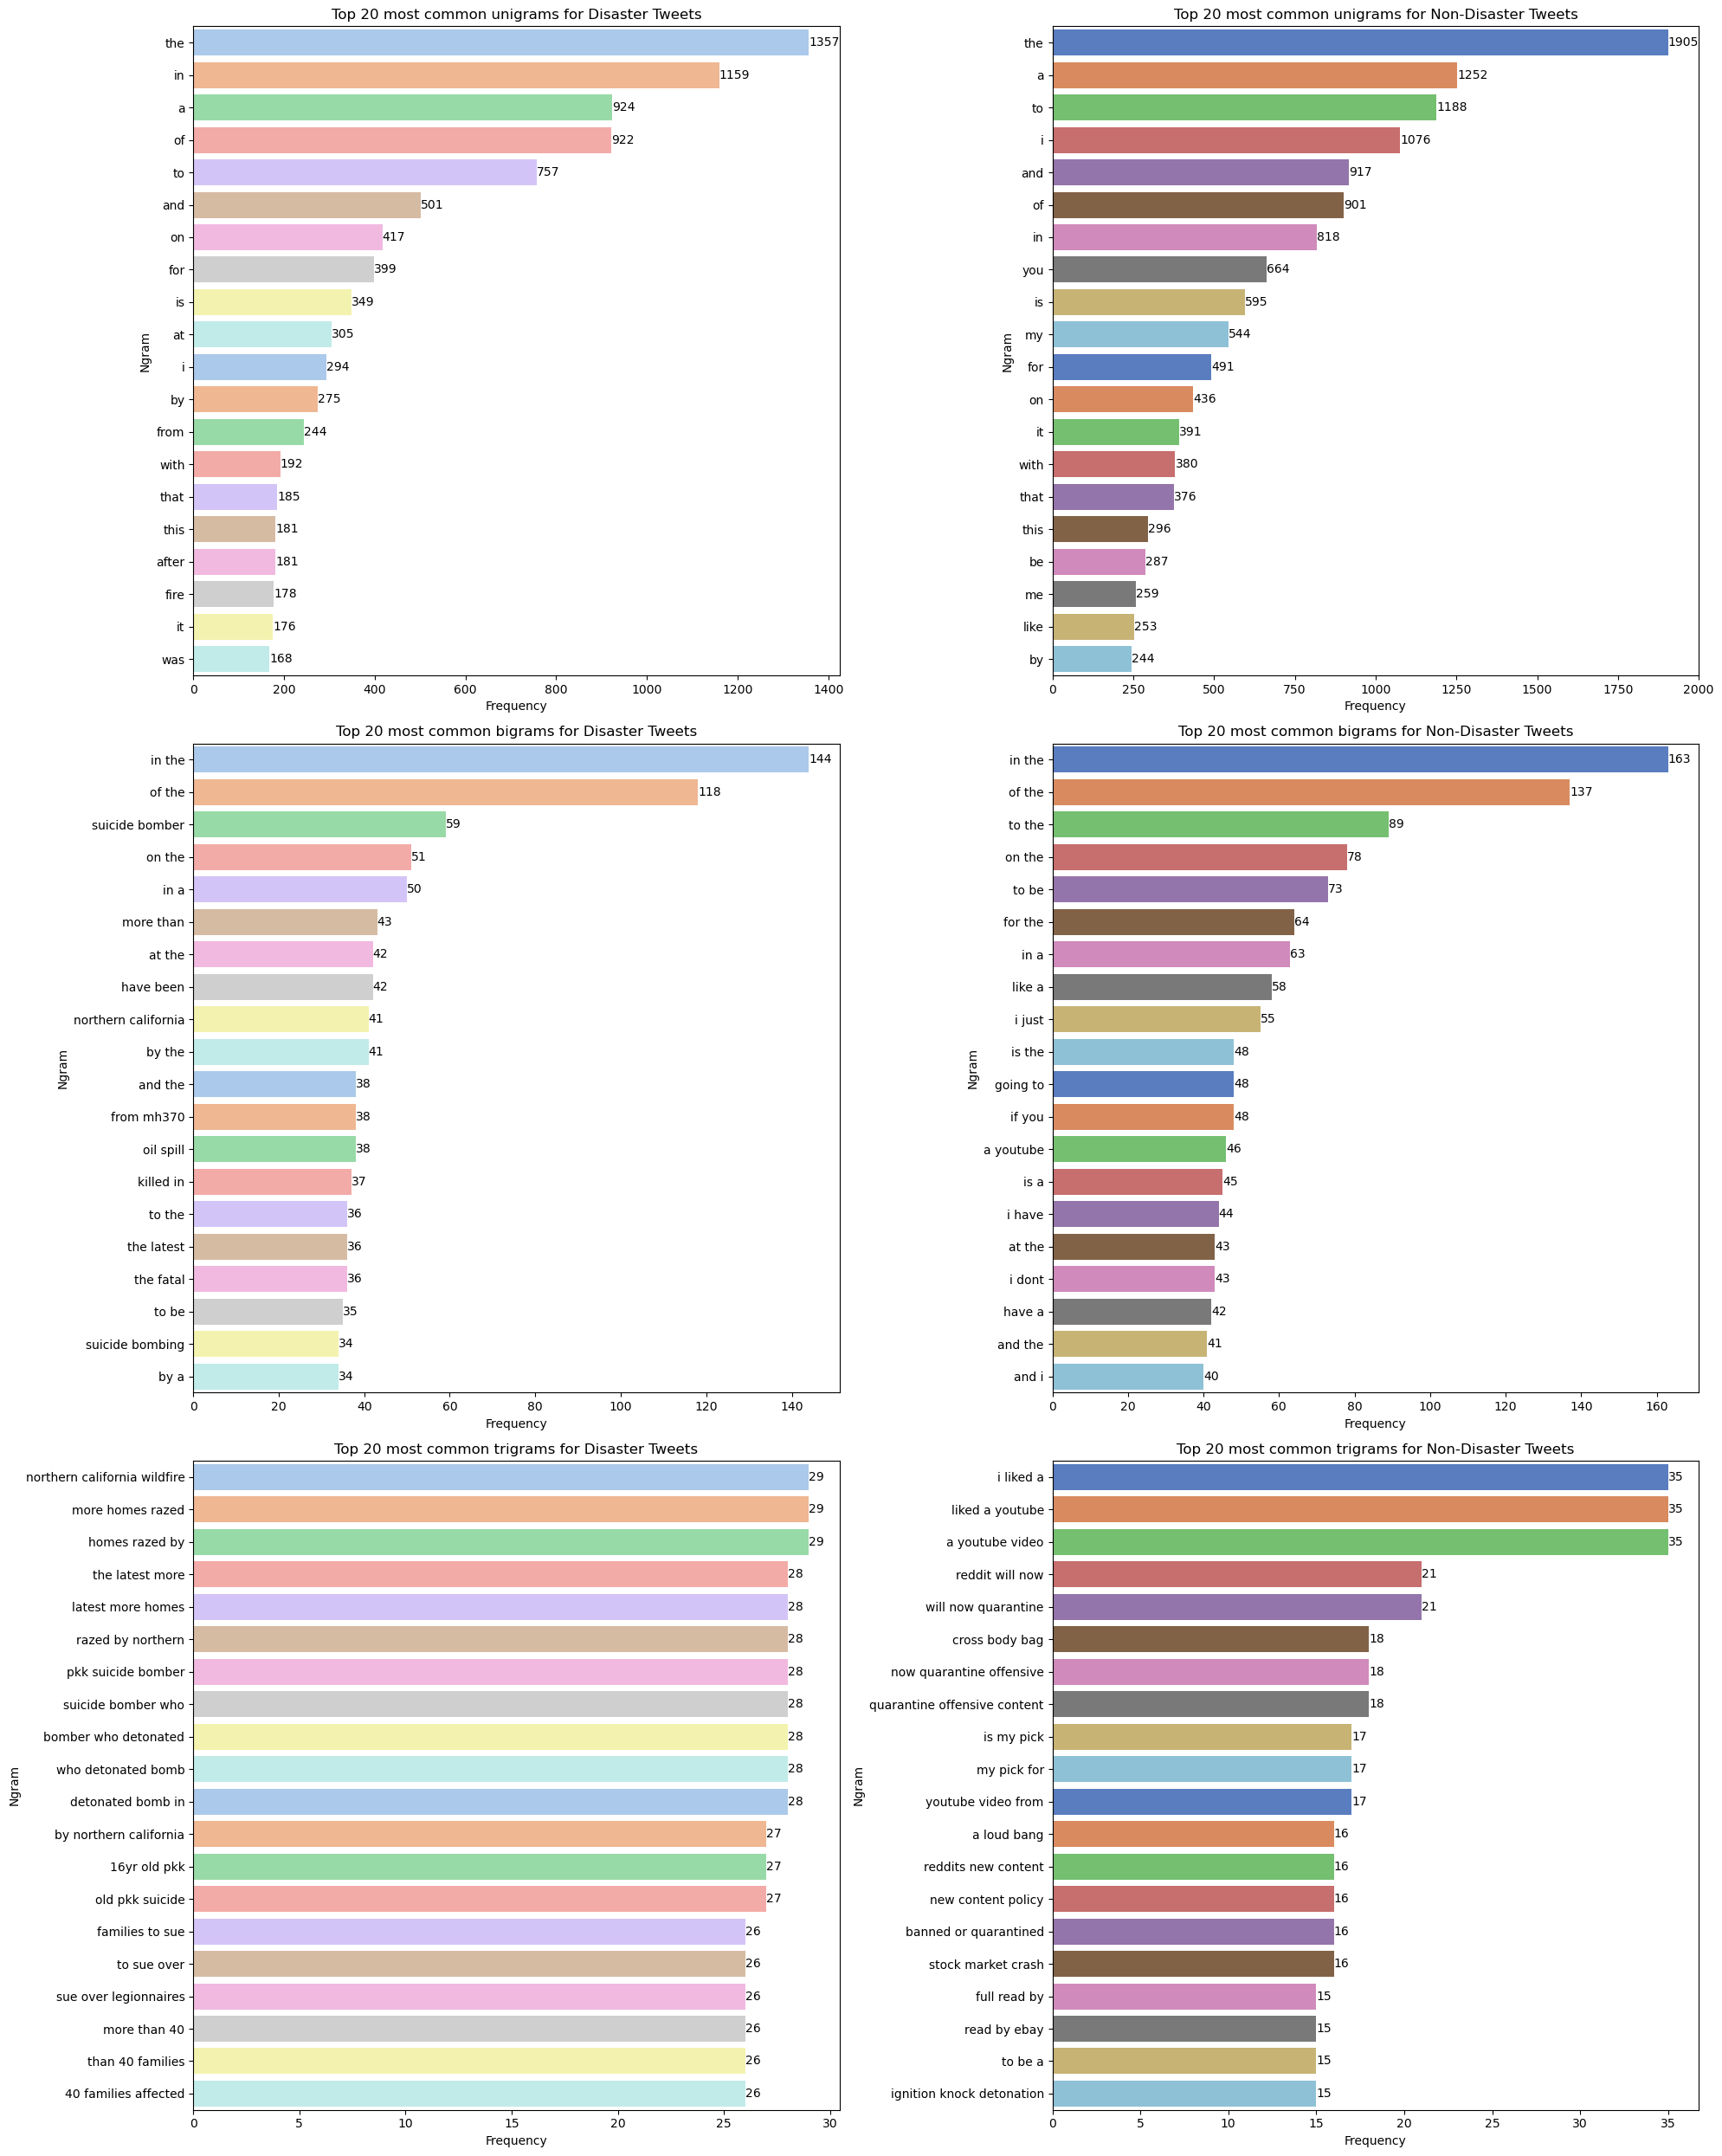

In [13]:
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

def generate_ngrams(text, n=1):
    tokens = text.split()
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

def count_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for text in texts:
        text = preprocess_text(text)
        for ngram in generate_ngrams(text, n):
            ngram_counts[ngram] += 1
    return ngram_counts

def plot_top_ngrams(ngram_counts, title, color, N, ax=None):
    counter = Counter(ngram_counts)
    df_ngrams = pd.DataFrame(counter.most_common(N), columns=['Ngram', 'Frequency'])
    if ax is None:
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Frequency', y='Ngram', data=df_ngrams, palette=color)
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel('Ngram')
    else:
        sns.barplot(x='Frequency', y='Ngram', data=df_ngrams, palette=color, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Ngram')

    for i, (_, freq) in enumerate(df_ngrams.iterrows()):
        ax.text(freq['Frequency'], i, freq['Frequency'], color='black', ha="left", va="center")


N = 20  
disaster_texts = train_copy[train_copy['target']==1]['text']
non_disaster_texts = train_copy[train_copy['target']==0]['text']

fig, axs = plt.subplots(3, 2, figsize=(20, 25))

disaster_unigrams = count_ngrams(disaster_texts, 1)
non_disaster_unigrams = count_ngrams(non_disaster_texts, 1)
plot_top_ngrams(disaster_unigrams, f'Top {N} most common unigrams for Disaster Tweets', 'pastel', N, ax=axs[0, 0])
plot_top_ngrams(non_disaster_unigrams, f'Top {N} most common unigrams for Non-Disaster Tweets', 'muted', N, ax=axs[0, 1])

disaster_bigrams = count_ngrams(disaster_texts, 2)
non_disaster_bigrams = count_ngrams(non_disaster_texts, 2)
plot_top_ngrams(disaster_bigrams, f'Top {N} most common bigrams for Disaster Tweets', 'pastel', N, ax=axs[1, 0])
plot_top_ngrams(non_disaster_bigrams, f'Top {N} most common bigrams for Non-Disaster Tweets', 'muted', N, ax=axs[1, 1])

disaster_trigrams = count_ngrams(disaster_texts, 3)
non_disaster_trigrams = count_ngrams(non_disaster_texts, 3)
plot_top_ngrams(disaster_trigrams, f'Top {N} most common trigrams for Disaster Tweets', 'pastel', N, ax=axs[2, 0])
plot_top_ngrams(non_disaster_trigrams, f'Top {N} most common trigrams for Non-Disaster Tweets', 'muted', N, ax=axs[2, 1])

plt.tight_layout()
plt.show()

In the unigram graphs, the word 'the' reigns supreme, boasting the highest frequency in both Disaster and Non-Disaster Tweets, with 1357 and 1905 occurrences, respectively. Following closely behind, 'in' secures the second spot in Disaster Tweets with 1159 occurrences, while 'a' takes the runner-up position in Non-Disaster Tweets with 1252 occurrences. 'A' maintains its significance as the third most common word in Disaster Tweets, appearing 924 times, whereas 'to' claims this spot in Non-Disaster Tweets with 1188 occurrences. 'Of' clinches the fourth position in Disaster Tweets with 922 appearances, while 'i' takes its place in Non-Disaster Tweets with 1076 occurrences. Finally, 'to' emerges as the fifth most frequent word in Disaster Tweets (757 occurrences), while 'and' secures this rank in Non-Disaster Tweets (917 occurrences).

In the bigram graphs, 'in the' emerges as the dominant pair, boasting the highest frequency in both Disaster and Non-Disaster Tweets, with 144 and 163 occurrences, respectively. Following closely behind, 'of the' secures the second position in both Disaster and Non-Disaster Tweets, with 118 and 137 occurrences, respectively. In Disaster Tweets, 'suicide bomber' claims the third spot with 59 occurrences, whereas 'to the' takes this place in Non-Disaster Tweets with 89 occurrences. 'On the' follows suit as the fourth most common bigram in both Disaster and Non-Disaster Tweets, with 51 and 78 occurrences, respectively. Lastly, in Disaster Tweets, 'in a' emerges as the fifth most frequent bigram, appearing 50 times, while 'to be' secures this position in Non-Disaster Tweets with 73 occurrences.

Moving onto trigram graphs, phrases like 'northern california wildfire,' 'more homes razed,' and 'homes razed by' dominate the Disaster Tweets with the highest word frequency of 29. Conversely, in Non-Disaster Tweets, phrases like 'i liked a,' 'liked a youtube,' and 'a youtube video' claim the top spot with a frequency of 35. Additionally, phrases such as 'the latest more,' 'latest more homes,' 'razed by northern,' 'pkk suicide bomber,' 'suicide bomber who,' 'bomber who detonated,' and 'detonated bomb in' emerge as the second highest in Disaster Tweets with a frequency of 28. Meanwhile, 'reddit will now' and 'will now quarantine' hold this position in Non-Disaster Tweets with a frequency of 21.

These graphs showcase the nuanced differences in language usage between Disaster and Non-Disaster contexts. Disaster-related content tends to feature terms like 'wildfire,' 'homes razed,' and 'suicide bomber,' reflecting the urgency and gravity of such situations. Conversely, Non-Disaster Tweets are marked by more commonplace language, with phrases like 'liked a youtube video' and 'reddit will now quarantine' dominating the discourse. 

#### Data Cleaning and Standardized Text

In [14]:
stop_words = stopwords.words('english')
stemmer = nltk.SnowballStemmer('english')

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map 
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


In [15]:
def cleaned_text(text):
    text = text.lower()
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
train['text_cleaned'] = train['text'].apply(cleaned_text)
test['text_cleaned'] = test['text'].apply(cleaned_text)

- Lowercasing: text = text.lower() converts all characters in the text to lowercase.
- Removing Punctuation: re.sub(r'[^\w\s]', '', text) removes any characters that are not alphanumeric or whitespace, including punctuation marks like periods, commas, and exclamation marks.
- Removing URLs: re.sub(r'https?://\S+|www\.\S+', '', text) removes URLs, matching both HTTP and HTTPS URLs as well as URLs without a protocol.
- Removing HTML tags: re.sub(r'<.*?>', '', text) removes HTML tags.
- Removing Emojis: emoji_pattern.sub(r'', text) removes emojis based on their Unicode code points.
- Tokenization: word_tokenize(text) tokenizes the text into individual words, spliting the text into words based on whitespace and punctuation.
- Removing Stopwords: [token for token in tokens if token not in stop_words] removes stopwords from the tokens, like "the", "is", "and", etc., that often don't carry much meaning.
- Stemming: [stemmer.stem(token) for token in tokens] stems each token using a stemming algorithm, reduces words to their root or base form, which helps in reducing the vocabulary size and capturing the essence of words. 

### Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

The chosen approach for text vectorization is based on the CountVectorizer method, which converts the raw text data into a matrix of token counts. This method transforms the text data into a numerical representation by counting the occurrences of each word in the vocabulary within each document (tweet). The resulting matrix, known as a document-term matrix (DTM), is then used as input for machine learning models.

To handle the textual data, a sequential neural network model architecture is employed, specifically utilizing LSTM (Long Short-Term Memory) units, which are a type of recurrent neural network (RNN). LSTMs are well-suited for NLP tasks because they can capture long-range dependencies and maintain information over extended sequences, making them effective for processing text data.

The preprocessing steps involve tokenizing the text, padding sequences to ensure uniform length, and embedding the sequences using pre-trained GloVe (Global Vectors for Word Representation) word embeddings. GloVe embeddings provide vector representations for words based on their co-occurrence statistics in a large corpus of text, capturing semantic relationships between words. These pre-trained embeddings are then used to initialize an embedding layer in the neural network model, enabling the model to leverage semantic information from the embeddings during training.

Hyperparameter tuning is performed to optimize the model's performance, including parameters such as recurrent dropout, dropout rate, LSTM units, and optimizer choice. The best-performing model architecture is selected based on its accuracy on a validation set. In addition to LSTM models, a GRU (Gated Recurrent Unit) architecture is also explored for comparison.

Evaluation metrics such as loss, accuracy, and learning curves (training/validation loss and accuracy over epochs) are analyzed to assess the model's performance and identify potential issues such as overfitting. Techniques like learning rate reduction and model checkpointing are employed to mitigate overfitting and improve generalization ability.

Overall, the selected model architecture (LSTM with better accuracy score) and preprocessing approach aim to effectively capture the semantic meaning of tweets and classify them into disaster and non-disaster categories with high accuracy. 

#### Encoding Target Variable

In [16]:
le = LabelEncoder()
le.fit(train['target'])

train['target_encoded'] = le.transform(train['target'])
train.head()

,id,keyword,location,text,target,text_cleaned,target_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,1


LabelEncoder to encode the target variable into numerical values, where 1 represents disaster tweets and 0 represents non-disaster tweets.

#### Text Vectorization and Splitting Data

In [17]:
x = train['text_cleaned']
y = train['target_encoded']

print(len(x), len(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

vect = CountVectorizer()
vect.fit(x_train)
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

7613 7613
5709 5709
1904 1904


Vectorizing data using the CountVectorizer, converting text into a matrix of token counts. The dataset is then split into training and testing sets, with the training set comprising 75% of the data and the testing set comprising 25%. Finally, the text data is transformed into document-term matrices (DTM).

#### Vocabulary Size Calculation

In [18]:
texts = train['text_cleaned']
target = train['target_encoded']
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

14476

Calculates the vocabulary size for the tokenized text data after preprocessing. It initializes a tokenizer, fits it on the preprocessed text data, and then calculates the vocabulary size by adding 1 to the length of the word index obtained from the tokenizer. In this case, the vocabulary size is determined to be 14476.

#### Padding and Embedding Sequences

In [19]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

test_texts = test['text_cleaned']
test_padded_sentences = pad_sequences(
    embed(test_texts),
    length_long_sentence,
    padding='post'
)

test_padded_sentences

array([[ 198, 1640,   56, ...,    0,    0,    0],
       [ 380,  207,  809, ...,    0,    0,    0],
       [ 139,    2,  586, ...,    0,    0,    0],
       ...,
       [ 763,  521,   54, ...,    0,    0,    0],
       [4848,  178,  129, ...,    0,    0,    0],
       [4618,  638, 1334, ...,    0,    0,    0]], dtype=int32)

Pad and embed the sequences of cleaned text data for both the training and test sets. Padding ensures that all sequences have the same length, and embedding converts the sequences of words into sequences of integers, where each integer corresponds to a word in the vocabulary.

#### Generating Word Embeddings from GloVe

In [20]:
embeddings_dictionary = dict()
embedding_dim = 100

with open('glove.twitter.27B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21063   , -0.010992  , -0.17552   , ..., -0.37547001,
         0.58029002,  0.16067   ],
       [ 0.066373  ,  1.09249997, -0.59674001, ...,  0.040076  ,
        -0.12083   , -0.1785    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20125   , -0.091671  ,  0.51243001, ..., -0.19316   ,
         0.33122   ,  0.25007999],
       [-0.076711  , -0.77710998, -0.75962001, ...,  0.23106   ,
         0.09527   , -0.15951   ]])

Utilizes pre-trained GloVe word embeddings to create vector representations for words in the dataset's vocabulary. Each word's vector representation is looked up in the GloVe embeddings dictionary, and if found, it is added to the embedding matrix. If a word is missing from GloVe embeddings, its corresponding row in the embedding matrix remains filled with zeros.

#### Train-Test Split for Text Classification

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

Splits the padded sentences (train_padded_sentences) and their corresponding target labels (target) into training and testing sets (X_train, X_test, y_train, y_test) with a test size of 25%.

### Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

#### Learning Rate Reduction and Model Checkpointing

In [22]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
checkpoint = ModelCheckpoint(
    'h5.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr2 = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
checkpoint2 = ModelCheckpoint(
    'h6.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

Creates two sets of callbacks for reducing the learning rate on plateaus (reduce_lr, reduce_lr2) and for saving the best model weights based on validation loss (checkpoint, checkpoint2).

#### LSTM Model with GloVe Embeddings and Hyperparameter Tuning

In [23]:
def glove_lstm(recurrent_dropout, dropout_rate, lstm_units, optimizer):
    model = Sequential()
    
    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1],
        trainable=False
    )
    model.add(embedding_layer)
    
    model.add(Bidirectional(LSTM(
        lstm_units, 
        return_sequences=True, 
        recurrent_dropout=recurrent_dropout
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# hyperparameters to tune
recurrent_dropouts = [0.2, 0.3]
dropout_rates = [0.4, 0.5]
lstm_units_list = [128, 256]
optimizers = ['rmsprop', 'sgd']

best_accuracy1 = 0
best_hyperparameters1 = {}

for recurrent_dropout in recurrent_dropouts:
    for dropout_rate in dropout_rates:
        for lstm_units in lstm_units_list:
            for optimizer in optimizers:
                model = glove_lstm(recurrent_dropout=recurrent_dropout, dropout_rate=dropout_rate, lstm_units=lstm_units, optimizer=optimizer)
                print(f'Current Hyperparameters = recurrent_dropout:{recurrent_dropout}, dropout_rate:{dropout_rate}, lstm_units:{lstm_units}, optimizer:{optimizer}')
                history = model.fit(
                    X_train, 
                    y_train, 
                    epochs=7,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[reduce_lr, checkpoint]
                )
                loss, accuracy = model.evaluate(X_test, y_test)
                if accuracy > best_accuracy1:
                    best_accuracy1 = accuracy
                    best_hyperparameters1 = {'recurrent_dropout': recurrent_dropout, 'dropout_rate': dropout_rate, 'lstm_units': lstm_units, 'optimizer': optimizer}
                
print("Best Hyperparameters:", best_hyperparameters1)
print("Best Accuracy:", best_accuracy1)


Current Hyperparameters = recurrent_dropout:0.2, dropout_rate:0.4, lstm_units:128, optimizer:rmsprop
Epoch 1/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5606 - loss: 0.6842
Epoch 1: val_loss improved from inf to 0.68701, saving model to h5.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5607 - loss: 0.6841 - val_accuracy: 0.5914 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/7
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5971 - loss: 0.6615
Epoch 2: val_loss improved from 0.68701 to 0.67302, saving model to h5.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5973 - loss: 0.6614 - val_accuracy: 0.6287 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 3/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6353 - loss: 0.6346
Epoch 3: val_loss improved from 0.67302 to 0.63470, saving model to h5.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6354 - loss: 0.6345 - val_accuracy: 0.6565 - val_loss: 0.6347 - learning_r

Created a bidirectional LSTM model with specified hyperparameters like recurrent dropout, dropout rate, LSTM units, and optimizer. It iterates through different combinations of these hyperparameters, training and evaluating the model on a validation set. The best hyperparameters yielding the highest accuracy on the validation set are recorded and printed. In this case, the best accuracy achieved is 74.53% with hyperparameters: recurrent dropout of 0.2, dropout rate of 0.4, 128 LSTM units, and RMSprop optimizer.

#### Generating Predictions with Best Model

In [24]:
best_model = glove_lstm(
    recurrent_dropout=best_hyperparameters1['recurrent_dropout'],
    dropout_rate=best_hyperparameters1['dropout_rate'],
    lstm_units=best_hyperparameters1['lstm_units'],
    optimizer=best_hyperparameters1['optimizer']
)

best_model.build((None, length_long_sentence))
best_model.load_weights('h5.keras')
test_predictions = best_model.predict(test_padded_sentences)


  1/102 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step

/Users/maychan/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Loads the weights of the best-performing LSTM model, previously identified through hyperparameter tuning. It generates predictions on a test dataset using this trained model. The model architecture is defined based on the best hyperparameters obtained from the previous tuning process.

#### Training and Validation Metrics Visualization

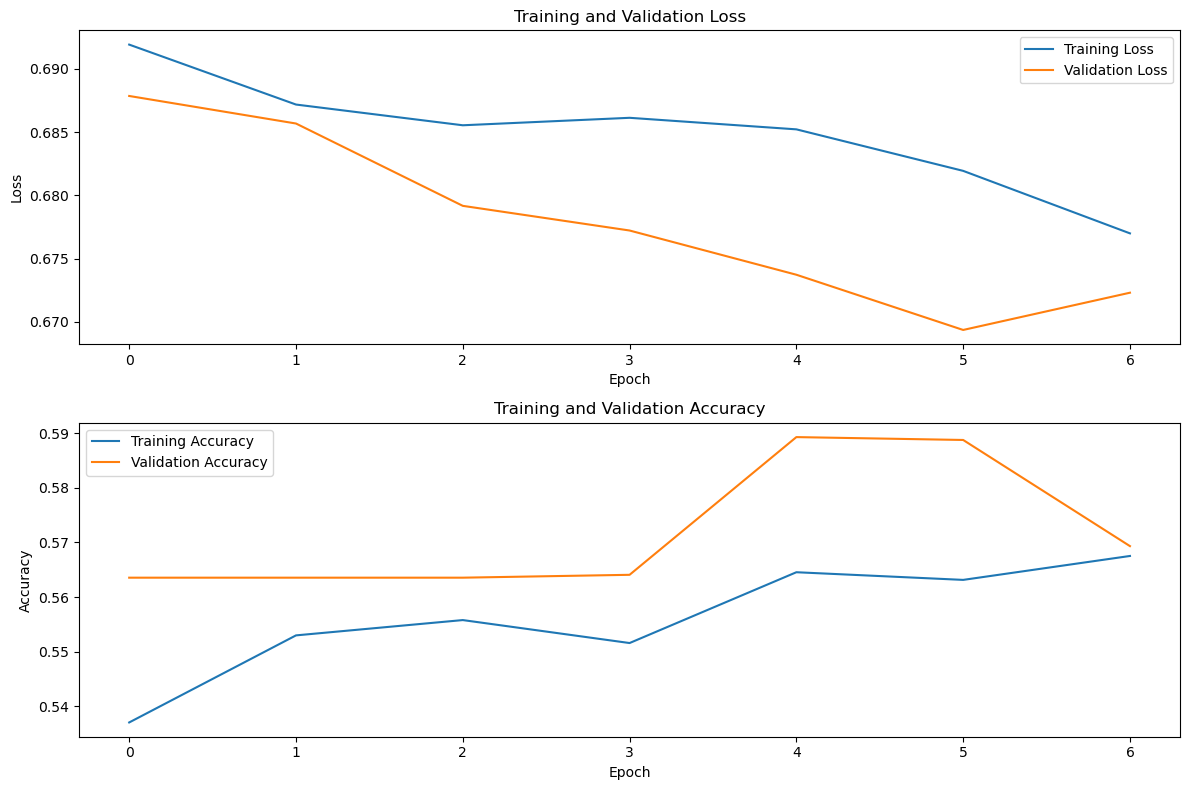

In [24]:
plt.figure(figsize=(12, 8))

# Plotting loss and val_loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy and val_accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In terms of validation loss, the model exhibits a downward trend in both training and validation loss throughout most epochs, yet a notable divergence occurs shortly after the fifth epoch. While the training loss steadily decreases from approximately 0.690 at the start to around 0.680 by the fifth epoch, validation loss follows a similar trajectory until the fifth epoch, where it starts increasing steadily thereafter, reaching around 0.670 by that point. This suggests a potential overfitting issue as the model's performance on unseen data begins to degrade after a certain point.

Regarding accuracy, the training model displays a gradual improvement in training accuracy, starting from below 0.54 and climbing to around 0.56 by the fifth epoch, after which it stabilizes. Conversely, validation accuracy remains relatively stable, hovering between 0.56 and 0.57 for the initial epochs, before experiencing a slight increase to 0.59 by the fourth epoch, and subsequently declining to around 0.56–0.57 by the sixth epoch. This stability in validation accuracy contrasts with the fluctuations observed in training accuracy, indicating a potential gap between the model's performance on training and validation datasets.

The graphs reveal that while the model demonstrates an overall improvement in training accuracy, suggesting effective learning, the increasing validation loss and the fluctuating validation accuracy after the fifth epoch indicate a loss of generalization ability, potentially due to overfitting.

#### Model Tuning with GRU

In [25]:
max_length = max(len(sequence) for sequence in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_length)

def create_model(max_length, dropout_rate, optimizer):
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=100)(input_layer)
    gru_layer = GRU(units=64, return_sequences=True)(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(gru_layer)
    dense_layer = Dense(64, activation='relu')(pooling_layer)
    dropout_layer = Dropout(rate=dropout_rate)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# hyperparameters to tune
dropout_rates = [0.3, 0.5]
batch_sizes = [64, 128]
optimizers = {'sgd': SGD, 'adagrad': Adagrad}
best_accuracy2 = 0
best_hyperparameters2 = {}

for dropout in dropout_rates:
    for batch_size in batch_sizes:
        for optimizer_name, optimizer_class in optimizers.items():
            optimizer_instance = optimizer_class()
            model = create_model(max_length, dropout_rate=dropout, optimizer=optimizer_instance)
            print(f'Current Hyperparameters = dropout_rate:{dropout}, batch_size:{batch_size}, optimizer:{optimizer_name}')
            history = model.fit(X_train, y_train, batch_size=batch_size, epochs=7, 
                                validation_data = (X_test, y_test)
                                ,callbacks=[reduce_lr2, checkpoint2] 
                                ,verbose=1)
            loss, accuracy = model.evaluate(X_test, y_test)
            if accuracy > best_accuracy2:
                best_accuracy2 = accuracy
                best_hyperparameters2 = {'dropout_rate': dropout, 'batch_size': batch_size, 'optimizer': optimizer_name}
                
print("Best Hyperparameters:", best_hyperparameters2)
print("Best Accuracy:", best_accuracy2)


Current Hyperparameters = dropout_rate:0.3, batch_size:64, optimizer:sgd
Epoch 1/7
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5381 - loss: 0.6909
Epoch 1: val_loss improved from inf to 0.68682, saving model to h6.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5386 - loss: 0.6909 - val_accuracy: 0.5636 - val_loss: 0.6868 - learning_rate: 0.0100
Epoch 2/7
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5641 - loss: 0.6865
Epoch 2: val_loss improved from 0.68682 to 0.68511, saving model to h6.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5646 - loss: 0.6864 - val_accuracy: 0.5636 - val_loss: 0.6851 - learning_rate: 0.0100
Epoch 3/7
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5653 - loss: 0.6850
Epoch 3: val_loss improved from 0.68511 to 0.68485, saving model to h6.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5655 - loss: 0.6849 - val_accuracy: 0.5636 - val_loss: 0.6848 - learning_rate: 0.0100
Epoch 4/7
86/90 ━━━━━━━━━━━━

Utilizes a GRU (Gated Recurrent Unit) architecture and is aimed at sentiment analysis, evaluating text data padded to the maximum length of the sequences. Through hyperparameter tuning, including dropout rates, batch sizes, and optimizers (such as SGD and Adagrad), the script iterates to identify the best combination. The best accuracy for this model is lower than the LSTM model even after hyperparameters tuning at 0.56355.

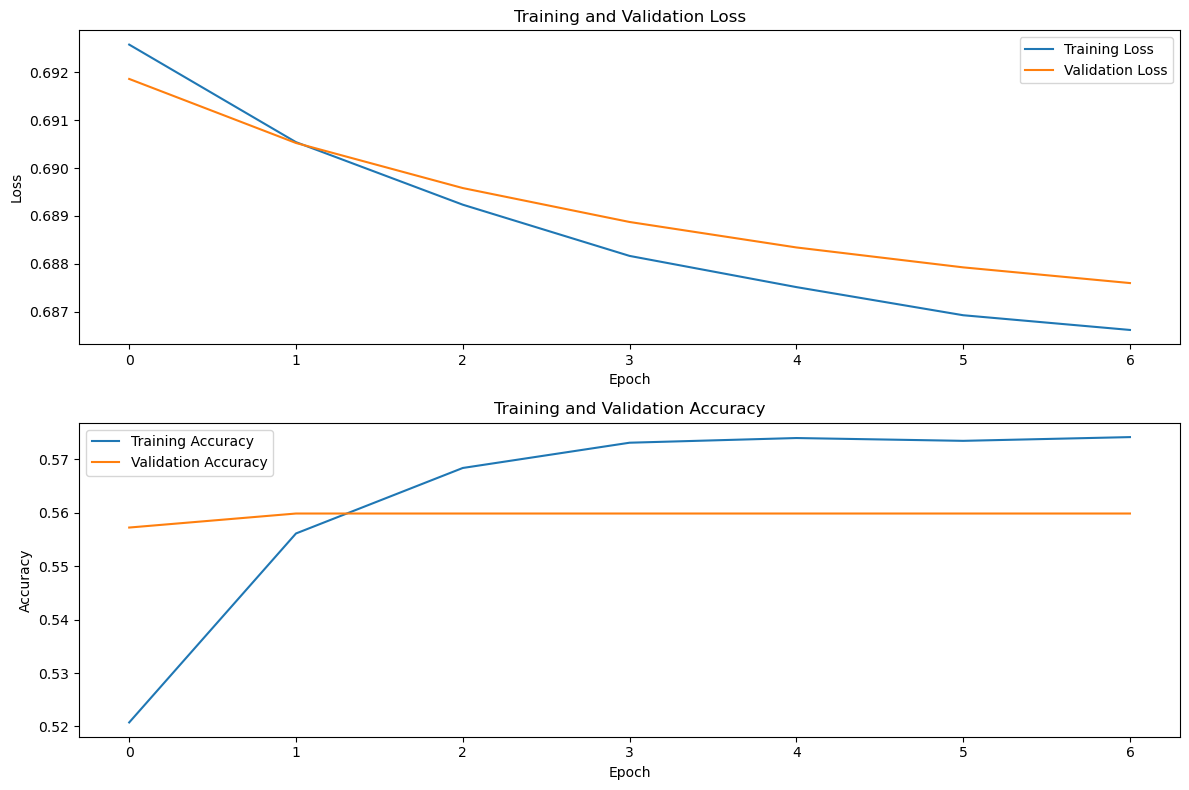

In [28]:
import matplotlib.pyplot as plt

# Plotting the curves
plt.figure(figsize=(12, 8))

# Plotting loss and val_loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy and val_accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In the training and validation loss graph, the model exhibits a gradual decrease in both training and validation loss as the number of epochs increases. The training loss starts above 0.692 and steadily decreases to below 0.687 by the end of training. Similarly, the validation loss starts around 0.692 and steadily decreases to below 0.687, mirroring the behavior of the training loss.

Concerning the training and validation accuracy graph, the training accuracy remains relatively stable throughout the epochs, hovering between 0.55 and 0.56. In contrast, the validation accuracy initially increases sharply from 0.52 to around 0.57 within the first few epochs and then remains relatively constant as the training progresses.

The graphs suggest that the model effectively learns from the training data, as evidenced by the decreasing loss values and the consistent training accuracy. However, the validation accuracy's initial spike followed by stabilization indicates that the model may be overfitting slightly to the training data, as the validation accuracy does not improve significantly beyond a certain point.

### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In conclusion, the experimentation with various model architectures and preprocessing techniques yielded valuable insights into text classification for disaster detection. The LSTM model with GloVe embeddings achieved the highest accuracy, indicating its effectiveness in capturing the semantic meaning of tweets and distinguishing between disaster-related and non-disaster-related content. The hyperparameter tuning process helped in optimizing model performance, with the selected hyperparameters significantly influencing the model's accuracy.

One notable finding was the impact of pre-trained GloVe embeddings on model performance. Leveraging semantic information encoded in the embeddings improved the model's ability to generalize to unseen data, resulting in better classification accuracy. Additionally, the use of LSTM units allowed the model to capture long-range dependencies in the text data, contributing to its overall effectiveness.

However, the analysis also revealed challenges such as potential overfitting, as indicated by diverging training and validation loss curves. While techniques like learning rate reduction and model checkpointing were employed to mitigate overfitting, further exploration of regularization techniques such as dropout and early stopping could be beneficial in improving model generalization.

Furthermore, the comparison with a GRU model highlighted the importance of architecture selection in achieving optimal performance. While the LSTM model outperformed the GRU model in terms of accuracy, the GRU model still provided valuable insights into alternative architectures for text classification tasks.

Moving forward, additional avenues for improvement could include exploring ensemble methods to combine multiple models for enhanced performance, experimenting with different pre-processing techniques such as stemming and lemmatization, and incorporating domain-specific features or external datasets to further enhance model robustness. Additionally, ongoing monitoring and fine-tuning of model hyperparameters based on real-world performance feedback could help ensure continued effectiveness in disaster detection applications. Overall, this experimentation process served as a valuable learning experience, highlighting the importance of iterative refinement and exploration in the pursuit of accurate and reliable text classification models.

In [25]:
binary_predictions = [1 if prediction >= 0.5 else 0 for prediction in test_predictions]

# Prepare the predictions for submission
submission = pd.DataFrame({'id': test['id'], 'target': binary_predictions})
submission.to_csv('submission.csv', index=False)

In [ ]:
Turing. "Word Embeddings in NLP: A Complete Guide." Turing Knowledge Base. https://www.turing.com/knowledge-base/word-embeddings-in-nlp/.
